# 2D GRF data Regression with domain-decomposed OpFlow
case1, scatter observations

run ``2D_domain_decomposed_GRF_prior.ipynb`` first

### load necessary libraries

In [1]:
from __future__ import division

from sklearn import cluster, datasets, mixture
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic
import torch
import torch.nn as nn 
from math import pi 
import torch.nn.functional as F
from torch.nn.parameter import Parameter

from torch.distributions.multivariate_normal import MultivariateNormal
import math
from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate
import pylab as plt
import statsmodels.api as sm
#from random_fields import *

import timeit
from matplotlib.colors import TwoSlopeNorm

In [2]:
import os

#os.environ['CUDA_VISIBLE_DEVICES'] = "5"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_num_threads(1)

In [3]:
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor

def GaussianProcess_2C(ndim, length_scale, nu, n_samples, return_kernel=False, nchannel = 1):
    x = np.linspace(0, 1, ndim)
    y = np.linspace(0, 1, ndim)
    XX, YY = np.meshgrid(x, y)
    XX = XX.reshape(-1, 1)
    YY = YY.reshape(-1, 1)
    X = np.concatenate([XX, YY], axis=1)
    print(X.shape)
    kernel = 1.0 * Matern(length_scale=length_scale, length_scale_bounds=(1e-1, 10.0), nu=nu)
    gpr_model = GaussianProcessRegressor(kernel=kernel)
    y_mean, y_std = gpr_model.predict(X, return_std=True)
    if nchannel == 1:
        y_samples = gpr_model.sample_y(X, n_samples)[:,:,np.newaxis]
    else:
        arr = []
        a = gpr_model.sample_y(X, n_samples*nchannel)[:,:,None]
        for i in range(nchannel):
            arr.append(a[:,n_samples*i:n_samples*(i+1),:])
        y_samples = np.concatenate(arr, axis=-1)
        assert(y_samples.shape == np.zeros([ndim*ndim, n_samples, nchannel]).shape)
        
    if return_kernel:
        return torch.tensor(y_samples), kernel(X), gpr_model
    else:
        return torch.tensor(y_samples)
    
def compute_acovf(z):
    # z shape : [n, ndim, ndim]
    res = z.shape[-1]
    z_hat = torch.fft.rfft2(z)
    acf = torch.fft.irfft2(torch.conj(z_hat) * z_hat)
    acf = torch.fft.fftshift(acf).mean(dim=0) / z[0].numel() # ndim*ndim
    acf_r = acf.view(-1).cpu().detach().numpy()
    lags_x, lags_y = torch.meshgrid(torch.arange(res) - res//2, torch.arange(res) - res//2)
    lags_r = torch.sqrt(lags_x**2 + lags_y**2).view(-1).cpu().detach().numpy()

    idx = np.argsort(lags_r)
    lags_r = lags_r[idx]
    acf_r = acf_r[idx]

    bin_means, bin_edges, binnumber = binned_statistic(lags_r, acf_r, 'mean', bins=np.linspace(0.0, res, 50))
    return bin_edges[:-1], bin_means

### dataset parameters and preparation

In [4]:
ntrain = 20000
nchannel = 1
ndim = 32
batch_size = 256

length_scale_x = 0.5
nu_x = 1.5

length_scale_z = 0.1
nu_z = 0.5



Starting up. Generate GRF samples
(1024, 2)
(1024, 2)


/home/yshi5/miniconda3/envs/Pytorch/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755849709/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


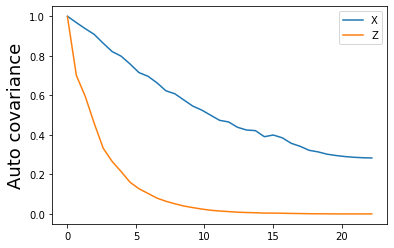

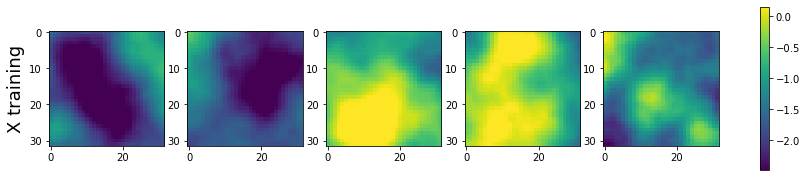

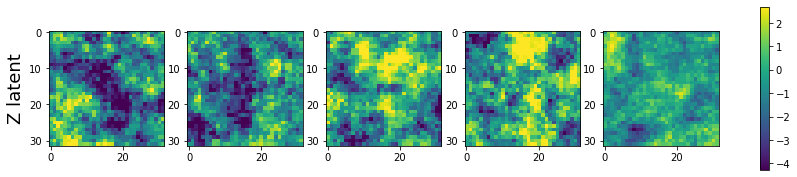

In [5]:
print("Starting up. Generate GRF samples")
import statsmodels.api as sm

np.random.seed(22)

x_train = GaussianProcess_2C(ndim, length_scale_x, nu_x, ntrain, return_kernel=False, nchannel=nchannel)
x_train = x_train.float().permute([1,0,2]).reshape(-1, ndim, ndim, nchannel)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train), batch_size=batch_size, shuffle=True,pin_memory=False)

## calculate the autocov 
z_train, kernel, z_gpmodel = GaussianProcess_2C(ndim, length_scale_z, nu_z, 2*ntrain, return_kernel=True, nchannel=nchannel)
z_train = z_train.float().permute([1,0,2]).reshape(-1, ndim, ndim, nchannel)
z_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(z_train), batch_size=batch_size, shuffle=True,pin_memory=False)

## calculate the statistics 
x_distance, x_acovf_mean = compute_acovf(x_train[:,:,:,0])
z_distance, z_acovf_mean = compute_acovf(z_train[:,:,:,0])

plt.plot(x_distance, x_acovf_mean, label='X')
plt.plot(z_distance, z_acovf_mean, label='Z')
plt.legend()
plt.ylabel("Auto covariance", fontsize=18)

fig, ax = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    x = x_train[i,:,:,0].squeeze()
    ax[i].imshow(x, vmin=-2, vmax=2)
    if i == 0:
        ax[i].set_ylabel('X training', fontsize=18)

#cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
bar = ax[4].imshow(x)
fig.colorbar(bar, ax=ax)
#plt.show()

fig, ax = plt.subplots(1,5, figsize=(15,3))    
for i in range(5):
    z = z_train[i,:,:,0].squeeze()
    ax[i].imshow(z, vmin=-2, vmax=2)
    if i == 0:
        ax[i].set_ylabel('Z latent', fontsize=18)
              
bar = ax[4].imshow(z)
fig.colorbar(bar, ax=ax)

# load dataset

In [6]:
def kernel_loc(in_chan=2, up_dim=32):
    """
        Kernel network apply on grid
    """
    layers = nn.Sequential(
                nn.Linear(in_chan, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, 1, bias=False)
            )
    return layers

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, dim1, dim2,modes1 = None, modes2 = None):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """
        in_channels = int(in_channels)
        out_channels = int(out_channels)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dim1 = dim1 #output dimensions
        self.dim2 = dim2
        if modes1 is not None:
            self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
            self.modes2 = modes2
        else:
            self.modes1 = dim1//2-1 #if not given take the highest number of modes can be taken
            self.modes2 = dim2//2 
        self.scale = (1 / (2*in_channels))**(1.0/2.0)
        self.weights1 = nn.Parameter(self.scale * (torch.randn(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)))
        self.weights2 = nn.Parameter(self.scale * (torch.randn(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x, dim1 = None,dim2 = None):
        if dim1 is not None:
            self.dim1 = dim1
            self.dim2 = dim2
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1 , dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft)
        #x = torch.fft.irfft2(out_ft, s=(self.dim1, self.dim2))
        return x



class pointwise_op(nn.Module):
    def __init__(self, in_channel, out_channel,dim1, dim2):
        super(pointwise_op,self).__init__()
        self.conv = nn.Conv2d(int(in_channel), int(out_channel), 1)
        self.dim1 = int(dim1)
        self.dim2 = int(dim2)

    def forward(self,x, dim1 = None, dim2 = None):
        if dim1 is None:
            dim1 = self.dim1
            dim2 = self.dim2
        x_out = self.conv(x)
        #x_out = torch.nn.functional.interpolate(x_out, size = (dim1, dim2),mode = 'bicubic',align_corners=True)
        return x_out

In [7]:
class FNO2d(nn.Module):
    def __init__(self, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        #self.modes1 = modes1
        #self.modes2 = modes2
        self.width = width
        self.padding = 0 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)
        
        self.conv0 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)

        self.conv1 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)
        
        self.conv2 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)

        self.conv3 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)
        
        self.w0 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.w1 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.w2 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.w3 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.fc1 = nn.Linear(self.width, 2*self.width)
        # first three are normalized 3C waveforms, last three are associated PGAs
        self.fc2 = nn.Linear(2*self.width, 2) # s and t


    def forward(self, x):
        res1 = x.shape[1]
        res2 = x.shape[2]
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
         
        x_fc0 = self.fc0(x)
        x_fc0 = F.gelu(x_fc0)
        
        x_fc0 = x_fc0.permute(0, 3, 1, 2)
        #x_fc0 = F.pad(x_fc0, [0,self.padding, 0,self.padding])
        
        x1 = self.conv0(x_fc0)
        x2 = self.w0(x_fc0)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        x = F.gelu(x)
        x = x.permute(0, 2, 3, 1)

        x_fc1 = self.fc1(x)
        x_fc1 = F.gelu(x_fc1)

        x_out = self.fc2(x_fc1)

        return x_out
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [8]:
class ActNorm(nn.Module):
    def __init__(self, in_channel, logdet=True):
        super().__init__()
        
        self.loc = nn.Parameter(torch.zeros(1, 1, 1, in_channel))
        self.log_scale = nn.Parameter(torch.zeros(1, 1, 1, in_channel))

        self.register_buffer("initialized", torch.tensor(0, dtype=torch.uint8))
        self.logdet = logdet

    def initialize(self, input):
        with torch.no_grad():
            #flatten = input.permute(1, 0, 2).contiguous().view(input.shape[1], -1)
            mean = input.mean(dim=(0,1,2)).unsqueeze(0).unsqueeze(1).unsqueeze(2)
            std = input.std(dim=(0,1,2)).unsqueeze(0).unsqueeze(1).unsqueeze(2)

            self.loc.data.copy_(-mean)
            self.log_scale.data.copy_(torch.log(1 / (std + 1e-6)))

    def forward(self, input):
        batch_size, ndim1, ndim2, _ = input.shape

        if self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)
            
        scale = torch.exp(self.log_scale)
        output = scale * (input + self.loc)        

        logdet = batch_size * ndim1 * ndim2 * self.log_scale.sum() #pointwise operation
        
        return output, logdet


    def inverse(self, output):
        #_, length, wdith, _ = output.shape
        scale = torch.exp(self.log_scale)
        output = output / scale - self.loc
        #logdet = -1.0 * width * length * self.log_scale.sum()
        
        #return output, logdet
        return output

In [9]:
class AffineCoupling(nn.Module):
    def __init__(self, width, block_dim):
        super(AffineCoupling, self).__init__()
        """
        A single affine coupling operator block
        This layer splits the input spatially and computes scale and shift functions
        It consists of two FNO networks to compute scale and shift functions
        The scale and shift functions are then used to transform the other
        half of the input function
        """
        self.width = width
        self.coupling = FNO2d(width)
        self.k = block_dim
        self.actnorm = ActNorm(1)

    def forward(self, z, flip=False):
        x = z
        x, log_actnorm = self.actnorm(x)
        n_rep = x.shape[2] // (2*self.k) + 1
        mask_a = torch.eye(2, device=x.device).bool()
        mask_a = mask_a.repeat_interleave(self.k, dim=1).repeat_interleave(self.k, dim=0).tile(n_rep, n_rep)

        mask_a = mask_a[:x.shape[1], :x.shape[2]]
        mask_b = torch.logical_not(mask_a)

        x1 = x * mask_a[None,:,:,None]
        x2 = x * mask_b[None,:,:,None]
        
        if flip:
            x2, x1 = x1, x2
            mask_b, mask_a = mask_a, mask_b

        # forward
        #print("x1. shape:{}".format(x1.shape))
        scale_shift = self.coupling(x1)
        #print("scale_shift shape:{}".format(scale_shift.shape))
        log_scale = scale_shift[:,:,:,0].unsqueeze(3)
        scale = torch.exp(log_scale)
        shift = scale_shift[:,:,:,1].unsqueeze(3)
        z1 = x1
        z2 = x2 * scale + shift

        z_hat = z1 + mask_b[None,:,:,None] * z2
        log_det = (log_scale * mask_b[None,:,:,None]).sum()
        log_det = log_det + log_actnorm
        
        return z_hat, log_det

    def inverse(self, z, flip=False):
        n_rep = z.shape[2] // (2*self.k) + 1
        mask_a = torch.eye(2, device=z.device).bool()
        mask_a = mask_a.repeat_interleave(self.k, dim=1).repeat_interleave(self.k, dim=0).tile(n_rep, n_rep)
        mask_a = mask_a[:z.shape[2], :z.shape[2]]
        mask_b = torch.logical_not(mask_a)
        z1 = z * mask_a[None,:,:,None]
        z2 = z * mask_b[None,:,:,None]

        if flip:
            z2, z1 = z1, z2
            mask_b, mask_a = mask_a, mask_b
            
        x1 = z1
        scale_shift = self.coupling(z1)
        log_scale = scale_shift[:,:,:,0].unsqueeze(3)
        scale = torch.exp(-log_scale)
        shift = scale_shift[:,:,:,1].unsqueeze(3)
        x2 = (z2 - shift) * scale
            
        x_hat = x1 + mask_b[None,:,:,None] * x2
        x_hat = self.actnorm.inverse(x_hat)
        
        return x_hat

In [10]:
class OpFlow(nn.Module):
    def __init__(self, width, blocks, block_base_dim, base_dist, pool_every=2, kernel=None, gp=None):
        super().__init__()
        self.flips = [True if i%2 else False for i in range(blocks)]
        block_dims = []
        block_dim = block_base_dim
        block_dims = block_base_dim

        self.bijectors = nn.ModuleList([
            AffineCoupling(width=width, block_dim=block_dims[i]) for i in range(blocks)
        ])
        if kernel is not None:
            self.kernel = kernel
        if gp is not None:
            self.gp = gp
        self.base_dist = base_dist
        
    def forward(self, x):
        batch_size = x.shape[0]
        log_dets = []

        for bijector, f in zip(self.bijectors, self.flips):
            x, log_det = bijector(x, flip=f)
            log_dets.append(log_det)
        z = x
        log_pz = self.base_dist.log_prob(z.reshape(x.shape[0], -1)).sum()
        
        return x, log_pz/batch_size, sum(log_dets)/batch_size
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z

In [11]:
lr = 1e-4
epochs = 200 
reg_fac = 1

n_train_tot = int(ntrain/batch_size)

block_base_dim = [16, 16, 8, 8, 4, 4, 2, 2, 1, 1]
#block_base_dim = [32, 32, 16, 16, 8, 8, 4, 4]
modes = ndim // 4
width = 32
blocks = len(block_base_dim)
base_mu = torch.zeros(ndim*ndim).float()
base_cov = torch.tensor(kernel).float()
base_dist = torch.distributions.MultivariateNormal(base_mu.to(device), scale_tril=torch.linalg.cholesky_ex(base_cov)[0].to(device))

# Model Trainig

In [12]:
G = OpFlow(width=width, blocks=blocks, block_base_dim=block_base_dim, base_dist=base_dist).to(device)

folder = "GRF2GRF_FNO_domain_decomposed_32x32_prior"
model_path = f"../paper_saved_models/{folder}/2D_domain_decomposed_249_prior.pt"
    
checkpoint = torch.load(model_path, map_location='cpu')
G.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [13]:
model= G

### check other statistical


In [14]:
x_hist_true, bin_edges = x_train.histogram(range=[-5.5,5.5], density=True)
x_pos = x_distance/ndim

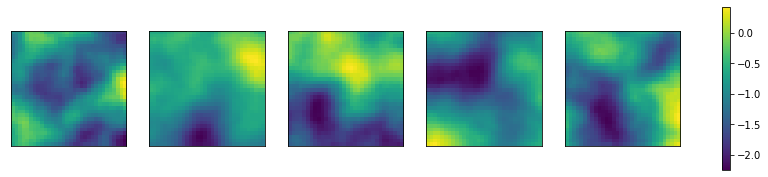

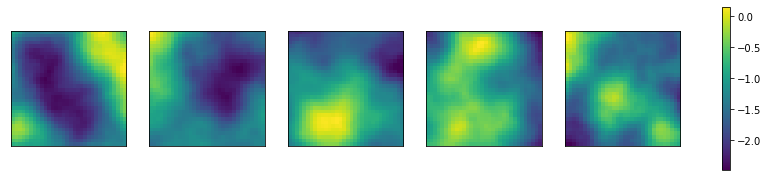

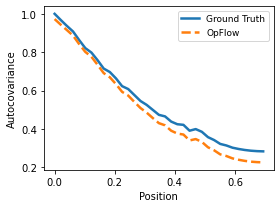

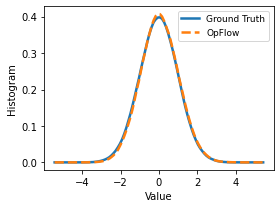

In [15]:
with torch.no_grad():
    Z = base_dist.rsample(sample_shape=(5,)).reshape(-1,ndim,ndim,1)
    X_hat = model.inverse(Z).detach().cpu().numpy()
    
    X_ground_truth = x_train[:5]
    Z_alt = base_dist.rsample(sample_shape=(5000,)).reshape(-1,ndim,ndim,1)

    z_train_iter = torch.split(Z_alt, 1000, dim=0)
    X_alt = []
    for i in range(len(z_train_iter)):
        z_train_temp = z_train_iter[i].to(device)
        x_alt = model.inverse(z_train_temp).detach().cpu()
        X_alt.append(x_alt)
        
    X_alt = torch.vstack(X_alt)        
    _, x_acovf = compute_acovf(X_alt.squeeze())
    _, x_acovf_true = compute_acovf(x_train.squeeze())
    x_hist, bin_edges_alt = X_alt.histogram(range=[-5.5,5.5], density=True)

    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat[i,:,:].squeeze()

        ax[i].imshow(x)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        #if i == 0:
            #ax[i].set_ylabel('OpFlow', fontsize=16)
        #ax[0].plot(x_ground_truth)
        #ax[0].set_title('Real')
        #ax[1].plot(x)
        #ax[1].set_title('OpFlow Generated')
        #ax[0].set_ylim([-3, 3])
        #ax[1].plot(sm.tsa.acovf(x, nlag=50))
        #ax[1].set_ylim([0.0, 1.0])

    #cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
    bar = ax[4].imshow(x)
    fig.colorbar(bar, ax=ax)

    #plt.show()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_opflow_samples.pdf")

    # covariance use position as x, adjust the size of histogram

    fig, ax = plt.subplots(1,5, figsize=(15,3))    
    for i in range(5):
        x_ground_truth = X_ground_truth[i,:,:].squeeze()
        ax[i].imshow(x_ground_truth)
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    bar = ax[4].imshow(x_ground_truth)
    fig.colorbar(bar, ax=ax)
    #plt.savefig(f"paper_pdf/{folder}/{folder}_ground_truth.pdf")


    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot(x_pos, x_acovf_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot(x_pos, x_acovf,c='#ff7f0e', ls='--', lw=2.5, label='OpFlow')
    #ax[0].set_ylim(0,1.1)
    ax.set_ylabel('Autocovariance')
    ax.set_xlabel('Position')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_autocov.pdf")
    
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true,  c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist, c='#ff7f0e', lw=2.5, ls='--',  label='OpFlow')
    ax.set_ylabel('Histogram')
    ax.set_xlabel('Value')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_statistic.pdf")


## 2D Regression (scatter observations)

In [16]:
from sklearn.gaussian_process.kernels import WhiteKernel

for param in G.parameters():
    param.requires_grad = False

In [17]:
ndim = 32
lr = 1e-3 
epochs = 5000
noise_level = 0.01

# create new 
berno_mask = torch.zeros((ndim, ndim))
mask_idx = np.random.choice(ndim*ndim, 32,replace=False)

#mask_idx = np.array([901, 863, 331, 436, 145, 866, 857, 195, 912, 817, 651, 408, 128, 704, 737, 138, 911, 
#574, 810, 641, 313, 197, 462, 727, 847, 682, 449, 1017, 503, 469, 44, 763]) #mask_idx used for the paper
berno_mask.reshape(-1)[mask_idx] = 1

berno_mask = berno_mask.reshape(32,32)
pos_mask = (berno_mask == 1)

u_obs_full = x_train[0:1,:,  :,0:1]
u_obs_part = u_obs_full[:,pos_mask,:].to(device)
u_obs_full = u_obs_full.squeeze()

mask_idx
array([ 901,  863,  331,  436,  145,  866,  857,  195,  912,  817,  651,
        408,  128,  704,  737,  138,  911,  574,  810,  641,  313,  197,
        462,  727,  847,  682,  449, 1017,  503,  469,   44,  763])

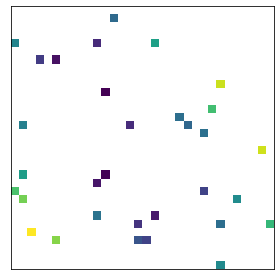

In [14]:
part_gt = u_obs_full.clone()
part_gt[~pos_mask] = np.nan
# plot the partial observation 
plt.imshow(part_gt)

plt.xticks([])
plt.yticks([])
#plt.title('Partial Observation', fontsize=16)
plt.tight_layout()

#plt.savefig('./demo_figure.png', transparent=True)
plt.show()

## Get MAP for a

In [19]:
class regression_opflow_a(nn.Module):
    def __init__(self, G):
        super().__init__()
        self.G = G
        self.a_target = nn.Parameter(torch.zeros(1,ndim, ndim, 1))
                                       
    def initialize(self, input):
        self.a_target.data = input.to(device)
        
    def target_u(self):
        return self.G.inverse(self.a_target)
        
    def logp(self):
        u = self.target_u()
        a, log_pa, log_det = self.G(u)
        return log_pa+log_det

    
def reg_process_a(reg_opflw_a, reg_optim_a, epochs, reg_scheduler=None):
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        # maximize a posterior 
        reg_optim_a.zero_grad()
        loss1 = -0.5*torch.sum((u_obs_part - reg_opflow_a.target_u()[:,pos_mask,:])**2)/noise_level
        #loss1 = -0.5*torch.sum((u_obs_part - reg_opflow_u.u_target[:,pos_mask,:])**2)/noise_level
        loss2 = reg_opflow_a.logp()
        loss = -(loss1 + loss2)
        loss.backward()
        reg_optim_a.step()
        losses[epoch] = loss.item()
        if reg_scheduler is not None:
            reg_scheduler.step()
        print("epcoh:{}, loss:{}".format(epoch, loss.item()))
    return losses


In [20]:
reg_opflow_a = regression_opflow_a(G).to(device)
reg_optim_a = torch.optim.Adam(reg_opflow_a.parameters(), lr=lr , weight_decay=1e-4)

In [ ]:
losses = reg_process_a(reg_opflow_a, reg_optim_a, epochs)

In [31]:
### validation of the MAP result

In [22]:
def plot_gpr_samples(gpr_model, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    x = np.linspace(0, 1, ndim)
    X = x.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    #ax.set_ylim([-3, 3])

In [23]:
u_opflow = reg_opflow_a.target_u().detach() # u_opflow : [ndim, ndim]
u_opflow_old = u_opflow #save a copy

x = np.linspace(0, 1, ndim)
y = np.linspace(0, 1, ndim)
XX, YY = np.meshgrid(x, y)
XX = XX.reshape(-1, 1)
YY = YY.reshape(-1, 1)
X = np.concatenate([XX, YY], axis=1)
print(X.shape)
kernel = 1.0 * Matern(length_scale=length_scale_x, length_scale_bounds='fixed', nu=nu_x)
gpr_model_ground_truth = GaussianProcessRegressor(kernel=kernel, alpha=noise_level)

x_obs = X[pos_mask.reshape(-1)]
y_obs = u_obs_part.squeeze().detach().cpu().numpy()
gpr_model_ground_truth = gpr_model_ground_truth.fit(x_obs, y_obs) #update the GP model

(1024, 2)


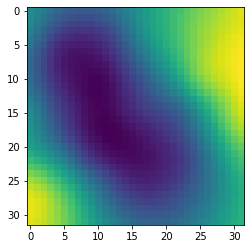

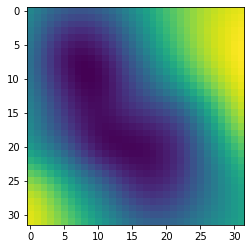

In [130]:
y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
y_mean = y_mean.reshape(32,32)
plt.imshow(u_opflow.clone().detach().cpu().squeeze())
plt.figure()
plt.imshow(y_mean)

### SGLD sampling

In [24]:
import sys
sys.path.insert(0, '../')

from imp import reload

import sampling_SGLD
import sampling_SGLD.samplers
import sampling_SGLD.SGLD
reload(sampling_SGLD.SGLD)
reload(sampling_SGLD.samplers)

from sampling_SGLD.samplers import LangevinDynamics

import copy
from tqdm import tqdm

## Regression on $\mathcal{A}$ Gaussian space

In [25]:
def nl_pdf_a(a, noise_level=noise_level):
    # return negative loglikehood
    u_from_a = G.inverse(a)
    loss1 = -0.5*torch.sum((u_obs_part - u_from_a[:,pos_mask,:])**2)/noise_level
    
    _, log_pa, log_det = G(u_from_a) 
    loss2 = log_pa + log_det
    
    loss = -(loss1 + loss2) 
    return loss

In [26]:
a_opflow_copy = reg_opflow_a.a_target.data.cpu().detach().clone()
u_opflow_copy = reg_opflow_a.target_u().cpu().detach().clone()

In [145]:

## initialize with the MAP result
x = torch.zeros_like(a_opflow_copy, requires_grad=True)
x.data = a_opflow_copy.to(device)
#x = nn.Parameter(u_opflow_copy, requires_grad=True).to(device)
#x = torch.zeros([2], requires_grad=True, device=device)

temperature = 1.0
max_itr = int(2e4)

# only designed for function SGLD
langevin_dynamics = LangevinDynamics(x,
                                     nl_pdf_a,
                                     lr=5e-3,
                                     lr_final=4e-3,
                                     max_itr=max_itr,
                                     device=device,
                                     base_dist = base_dist,
                                     temperature = temperature,
                                     )

hist_samples = []
loss_log = []
for j in tqdm(range(max_itr)):
    est, loss = langevin_dynamics.sample(epoch=j)
    loss_log.append(loss)
    if j % 10 == 0:
        hist_samples.append(est.cpu().numpy())

update
Tempertaure:1.0
start, white noise on A


100%|█████████████████████████████████████████████████████████████████████████████| 20000/20000 [51:36<00:00,  6.46it/s]


In [146]:
with torch.no_grad():
    a_samples_all = torch.Tensor(np.vstack(hist_samples)).to(device)
    u_samples_all = G.inverse(a_samples_all)

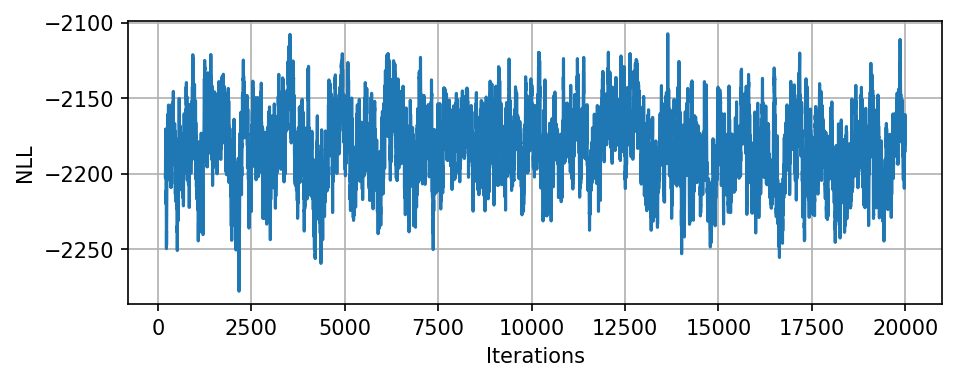

In [147]:
fig = plt.figure("training logs - net", dpi=150, figsize=(7, 2.5))
plt.plot(np.arange(200, len(loss_log)),loss_log[200:])
#plt.title("Unnormalized PDF")
plt.xlabel("Iterations")
plt.ylabel('NLL')
#plt.ylabel(r"$- \log \ \mathrm{N}(\mathbf{x} | \mu, \Sigma) + const.$")
plt.grid()

In [148]:
## calculate the mean predicted from OpFlow and Ground Truht 
est_samples = u_samples_all.detach().cpu().numpy()
est_samples = est_samples[20:]

sample_mean = np.mean(est_samples, axis=0).squeeze()
sample_std = np.std(est_samples, axis=0).squeeze()

### Final Plots

In [16]:

opflow_mean = sample_mean
opflow_std = sample_std

x = np.linspace(0, 1, ndim)
y = np.linspace(0, 1, ndim)
XX, YY = np.meshgrid(x, y)
XX = XX.reshape(-1, 1)
YY = YY.reshape(-1, 1)
X = np.concatenate([XX, YY], axis=1)
print(X.shape)
kernel = 1.0 * Matern(length_scale=length_scale_x, length_scale_bounds='fixed', nu=nu_x)
gpr_model_ground_truth = GaussianProcessRegressor(kernel=kernel, alpha=noise_level)

x_obs = X[pos_mask.reshape(-1)]
y_obs = u_obs_part.squeeze().detach().cpu().numpy()
gpr_model_ground_truth = gpr_model_ground_truth.fit(x_obs, y_obs) #update the GP model

(1024, 2)


In [17]:
saved_folder = 'GRF2GRF_set1_lr_1e_3_reg'
if not os.path.exists(f"Regression_results/{saved_folder}"):
    os.makedirs(f"Regression_results/{saved_folder}")

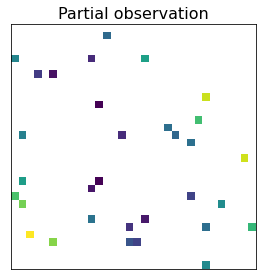

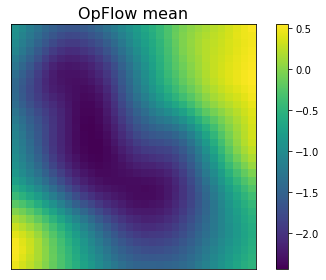

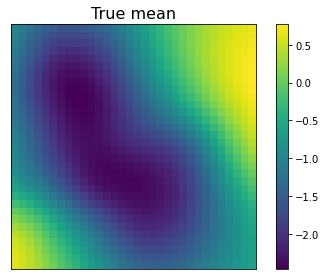

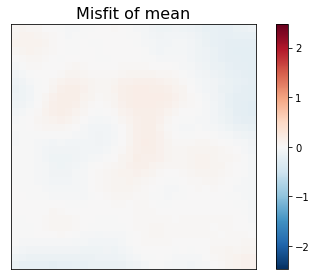

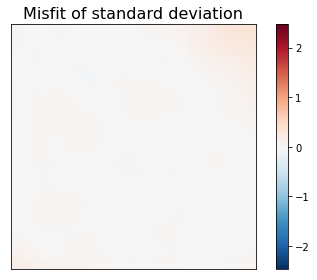

In [21]:
y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
y_mean = y_mean.reshape(32,32)
y_std = y_std.reshape(32,32)
y_samples = gpr_model_ground_truth.sample_y(X, 5000).reshape(32,32,-1)

part_gt = u_obs_full.clone()
part_gt[~pos_mask] = np.nan
# plot the partial observation 
plt.imshow(part_gt)
plt.xticks([])
plt.yticks([])
plt.title('Partial observation', fontsize=16)
plt.tight_layout()
#plt.savefig(f"paper_pdf/{folder}/ex2_partial_obs.pdf")
#plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_partial_obs.pdf")

plt.figure()
plt.imshow(sample_mean)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('OpFlow mean', fontsize=16)
plt.tight_layout()
#plt.savefig(f"paper_pdf/{folder}/ex2_opflow_mean.pdf")
#plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_opflow_mean.pdf")

plt.figure()
plt.imshow(y_mean)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('True mean', fontsize=16)
plt.tight_layout()
#plt.savefig(f"paper_pdf/{folder}/ex2_true_mean.pdf")
#plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_true_mean.pdf")

plt.figure()
relative_error = (sample_mean - y_mean)
norm = TwoSlopeNorm(vmin= y_mean.min(), vmax= -y_mean.min(),vcenter=0)
#plt.imshow(relative_error, vmin= y_mean.min(), vmax= y_mean.max())
plt.imshow(relative_error, norm=norm,cmap="RdBu_r")
#pc = plt.pcolormesh(x,y,z, norm=norm, cmap="RdBu_r")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Misfit of mean', fontsize=16)
plt.tight_layout()
plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_misfit_mean.pdf")

plt.figure()
relative_error = (sample_mean - y_mean)
norm = TwoSlopeNorm(vmin= y_mean.min(), vmax= -y_mean.min(),vcenter=0)
#plt.imshow(relative_error, vmin= y_mean.min(), vmax= y_mean.max())
plt.imshow(y_std-opflow_std, norm=norm, cmap="RdBu_r")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Misfit of standard deviation', fontsize=16)
plt.tight_layout()
plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_misfit_std.pdf")

### 

### Generate 3 representative scenarios

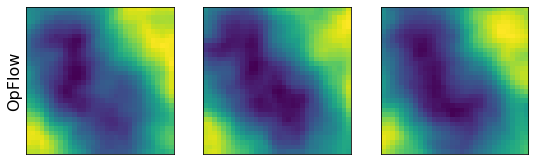

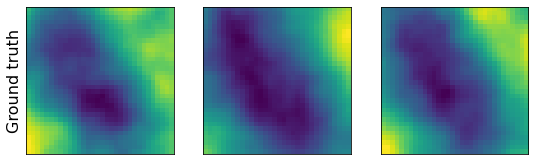

In [183]:
## each one generate 3 plots
## For the scenario, select 3 representative scenarios for OpFlow and Ground Truth

#random_idx = np.array([280, 73, 401]) #used for the paper
#random_idx_gt = np.array([25, 7,380]) #used for the paper
random_idx = np.random.choice(len(est_samples), 3, replace=False)
fig, ax = plt.subplots(1,3, figsize=(9,3))    
for i in range(3):
    x_opflow = est_samples[random_idx[i]].squeeze()
    ax[i].imshow(x_opflow)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('OpFlow', fontsize=16)
        
plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_scen_opflow.pdf")        

        
random_idx_gt = np.random.choice(len(y_samples), 3, replace=False)
fig, ax = plt.subplots(1,3, figsize=(9,3))    
for i in range(3):
    y_example = y_samples[:,:,random_idx_gt[i]].squeeze()
    ax[i].imshow(y_example)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('Ground truth', fontsize=16)
plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_scen_gt.pdf")   

In [181]:
import h5py
f = h5py.File(f"Regression_results/{saved_folder}.h5py", "w")
f.create_dataset('u_full_obs', data=u_obs_full.numpy())
f.create_dataset('x_obs_idx', data=mask_idx)
f.create_dataset('a_opflow_map', data=a_opflow_copy.squeeze().numpy())
f.create_dataset('sample_from_opflow', data=u_samples_all.detach().cpu().numpy())
f.close()